# IMPORTS

In [8]:
from utilities import *
import torch
import torch.nn as nn
#import mlflow
import pandas as pd
import math
from torch.nn import CrossEntropyLoss, Softmax, BatchNorm1d, BCEWithLogitsLoss, Sigmoid
import pickle
from scipy import stats
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.optim import Adam
from pathlib import Path
import random
import warnings

#ignore warning for computing mcc of 0.0
warnings.filterwarnings("ignore", category=RuntimeWarning)

### SETTING SEEDS ###
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "Data"  

BEPIPRED3_NON_SYNTHETIC_ESM = DATA_DIR / "BepiPred3Data" / "7NonSyntheticESMApproach" / "6CrossValidationNonSynthESM"
RESULTS_DIR = ROOT_DIR / "Results"
FIGURE_DIR = RESULTS_DIR / "NeuralNetworks" / "Figures"

### SET GPU OR CPU ###
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# MODEL

In [9]:
class MyDenseNet(nn.Module):
    def __init__(self,
                 esm_embedding_size = 1281,
                 fc1_size = 180,
                 fc2_size = 90,
                 fc3_size = 45,
                 fc1_dropout = 0.7,
                 fc2_dropout = 0.7,
                 fc3_dropout = 0.7,
                 num_of_classes = 2):
        super(MyDenseNet, self).__init__()
        
        
        self.esm_embedding_size = esm_embedding_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.fc3_size = fc3_size
        self.fc1_dropout = fc1_dropout
        self.fc2_dropout = fc2_dropout
        self.fc3_dropout = fc3_dropout
        
        self.ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc1_dropout),
                                      nn.Linear(fc1_size, fc2_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc2_dropout),
                                      nn.Linear(fc2_size, fc3_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc3_dropout),
                                      nn.Linear(fc3_size, num_of_classes))
        
 
    
    def forward(self, x):
        output = self.ff_model(x)                                               
        return output
    
    
class MyDenseNetWithBatchNorm(nn.Module):
    def __init__(self,
                 esm_embedding_size = 1281,
                 fc1_size = 180,
                 fc2_size = 90,
                 fc3_size = 45,
                 fc1_dropout = 0.7,
                 fc2_dropout = 0.7,
                 fc3_dropout = 0.7,
                 num_of_classes = 2):
        super(MyDenseNetWithBatchNorm, self).__init__()
        
        
        self.esm_embedding_size = esm_embedding_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.fc3_size = fc3_size
        self.fc1_dropout = fc1_dropout
        self.fc2_dropout = fc2_dropout
        self.fc3_dropout = fc3_dropout
        
        self.ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_size),
                                      nn.ReLU(),
                                      BatchNorm1d(fc1_size),
                                      nn.Dropout(fc1_dropout),
                                      nn.Linear(fc1_size, fc2_size),
                                      nn.ReLU(),
                                      BatchNorm1d(fc2_size),
                                      nn.Dropout(fc2_dropout),
                                      nn.Linear(fc2_size, fc3_size),
                                      nn.ReLU(),
                                      BatchNorm1d(fc3_size),
                                      nn.Dropout(fc3_dropout),
                                      nn.Linear(fc3_size, num_of_classes))
        
 
    
    def forward(self, x):
        output = self.ff_model(x)                                               
        return output
    
    


# FUNCTIONS

In [18]:
def prepare_train_and_valid_loaders(train_valid_path, batch_size = 4,
                                    shuffle_batches=True):
    
    X_train, y_train, X_val, y_val = load_data(train_valid_path)
    X_train = torch.from_numpy(X_train)
    y_train =  torch.from_numpy(y_train).long()
    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).long()
    
    train_dataset = list( zip(X_train, y_train) )
    valid_dataset = list( zip(X_val, y_val) )
        
    train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=shuffle_batches)
    valid_loader = DataLoader(valid_dataset, batch_size= batch_size, shuffle=shuffle_batches)
    
    return train_loader, valid_loader


def prepare_test_set_loader(test_path, batch_size = 1):
    
    X_test, y_test = load_data(test_path, test_data = True)
    
    X_test = torch.from_numpy(X_test)
    y_test =  torch.from_numpy(y_test).long()
   
    test_dataset = list ( zip(X_test, y_test) )
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
    
    return test_loader

### TRAINING FUNCTIONS ###
def train(model, trainloader, validloader, criterion, optimizer,
          model_save_path, epochs = 20):
    
    min_valid_loss = np.inf
    best_val_auc = 0
    training_validation_scores_per_epoch = list()
    
    for e in range(epochs):
        #training evaluation metrics
        train_loss = 0.0
        no_pred_power_train_loss = 0.0
        #validation evaluation metrics
        valid_loss = 0.0
        model.train()
        for data, labels in trainloader:
            #tranfer data to gpu if available
            data = data.to(device)
            labels = labels.to(device)
            #clear gradients
            optimizer.zero_grad()
            #forward pass
            output = model(data)
            labels = torch.flatten(labels)
            loss = criterion(output, labels)
            #calculate gradients
            loss.backward()
            #update weights
            optimizer.step()
            #acummulate loss, accuracy, mcc and auc
            train_loss += loss.item()
            
        model.eval()
        val_model_outputs = list()
        val_all_labels = list()
        for data, labels in validloader:
            data = data.to(device)
            labels = labels.to(device)             
            #forward pass
            output = model(data)
            val_model_outputs.append(output)
            labels = torch.flatten(labels)
            val_all_labels.append(labels)
            loss = criterion(output, labels)
            valid_loss += loss.item()
            
        #average loss
        avg_train_loss = round(train_loss / len(trainloader), 6)
        avg_val_loss = round(valid_loss / len(validloader), 6)        
        training_validation_scores_per_epoch.append((avg_train_loss, avg_val_loss))
        #print some stats
        print(f"Epoch: {e+1}")
        print(f"Avg. train loss: {avg_train_loss}")
        print(f"Avg. val loss: {avg_val_loss}")
        #save model which has the best validation loss
        if min_valid_loss > valid_loss:
            print(f"Summed validation loss decreased: {round(min_valid_loss, 4)}-->{round(valid_loss,4)})")
            min_valid_loss = valid_loss

            #get validation metrics
            val_model_outputs = torch.cat(val_model_outputs, axis=0)
            val_all_labels = torch.cat(val_all_labels, axis=0)
            _, val_auc, val_mcc, val_mcc_threshold = get_performance_metrics(val_model_outputs, val_all_labels)
            print(f"Optimized validation MCC for this model: {round(val_mcc,4)}, using threshold of {round(val_mcc_threshold,4)}")
            print(f"Validation AUC for this model: {round(val_auc,4)}")
            #save state dict
            if val_auc > best_val_auc:
                print(f"Validation AUC increased: {round(best_val_auc,4)} --> {round(val_auc,4)}. Saving model.")
                model_save = model_save_path.parent / f"{model_save_path.name}_bestCELoss"
                #save state dict
                save_pytorch_model(model, model_save)
                best_val_auc = val_auc
                best_mcc_threshold = val_mcc_threshold
    
    return training_validation_scores_per_epoch, best_mcc_threshold

def run_train_val_cv(dataset, results_dir, initial_learning_rate,
                     epochs, weight_decay, batch_size = 4):
    
    fold_paths = list( dataset.glob("*Fold*") )
    num_of_folds = len(fold_paths)
    fold_count = 1
    best_mcc_thresholds = list()
  
    for fold_path in fold_paths:
        
        print(f"Fold {fold_count} / {num_of_folds}")
        print(f"Loading data from {str(fold_path)}")
        
        train_loader, valid_loader = prepare_train_and_valid_loaders(fold_path, batch_size=batch_size,
                                                                                                                                )
        criterion = CrossEntropyLoss()
        criterion.to(device)
        model = MyDenseNet(fc1_dropout = 0.65,
                           fc2_dropout = 0.65,
                           fc3_dropout = 0.65)
#        model = MyDenseNetWithBatchNorm()
        print(f"Model architecture to be used\n{model}") 
        model.to(device)
        optimizer = Adam(model.parameters(), lr=initial_learning_rate, weight_decay=weight_decay)
        model_save_path = results_dir / "models" / f"Fold{fold_count}"
        
        training_validation_scores_per_epoch, best_mcc_threshold = train(model, train_loader, valid_loader, criterion, optimizer, model_save_path, epochs=epochs)
        best_mcc_thresholds.append(best_mcc_threshold)
#        generate_training_validation_plots(training_validation_scores_per_epoch, y_train_no_pred_power_ce_loss, y_val_no_pred_power_ce_loss, results_dir / "graphs" / f"Fold{fold_count}")
        fold_count += 1
        
    #save best thresholds for models
    outfile = open(results_dir / "models" / "best_mcc_threshold.pickle", "wb")
    pickle.dump(best_mcc_thresholds, outfile)
    
    
def evaluate_models_with_roc_curve(model, model_states, best_mcc_thresholds, data_loader, plot_title,
                                   figure_save_path):
    ensemble_model_outputs = list()
    num_of_models = len(model_states)
    f, ax = plt.subplots(figsize=(10,8))
    criterion = CrossEntropyLoss()
    all_preds = list()
    all_mccs = list()
    all_auc10 = list()
    all_aucs = list()
    y_true_repeat = list()
    all_recalls = list()
    all_precisions = list()
    all_f1_scores = list()
    all_accs = list()
    all_model_loss = list()
    all_pos_probs = list()
    all_thresh = list()
    overfit_threshs = list()
    
    for i in range(num_of_models):
        model_state = model_states[i]
        opt_thresh = best_mcc_thresholds[i] 
    
        model_outputs = list()
        all_labels = list()
    
        
        model.load_state_dict(torch.load(model_state))
        model.eval()
    
        for data, labels in data_loader:
    
  
            output= model(data)
#            output = output.squeeze()
            model_outputs.append(output)
#            labels = torch.flatten(labels)
            all_labels.append(labels)
            
        
        #create ROC curve
        model_outputs = torch.cat(model_outputs, axis=0)
        all_labels = torch.cat(all_labels, axis=0)
        model_loss = criterion(model_outputs, all_labels)
        y_true_no_pad, y_pos_prob_no_pad = get_labels_preds_and_posprob_without_padding(model_outputs, all_labels)
        all_pos_probs.append(y_pos_prob_no_pad)
        y_true_repeat.append(y_true_no_pad)
        
#        all_y_true = all_labels.cpu().detach().tolist()
#        all_y_pos_prob = sigmoid(model_outputs).cpu().detach().tolist()

        fpr, tpr, auc, overfit_thresh = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, y_pos_prob_no_pad)
        auc10 = compute_auc10(fpr, tpr)
        acc, mcc, recall, precision, f1_score, predictions = metrics_with_threshold(y_true_no_pad, y_pos_prob_no_pad, opt_thresh)
        
        all_thresh.append(round(opt_thresh,3))
        overfit_threshs.append(round(overfit_thresh,3))
        
        print(f"Fold{i+1}")
        print(f"AUC10: {round(auc10,4)}")
        print(f"Neg. log. likelihood loss: {round(model_loss.item(),4)} Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
        print(f"Positive recall: {recall} Precision: {round(precision,4)} F1-score: {round(f1_score,4)}")
        get_top_x_pos_probs_scores(y_pos_prob_no_pad, y_true_no_pad, opt_thresh, top=200)
        ax.plot(fpr, tpr, label = f"Fold{i+1} AUC: {round(auc,4)}")
        
        
        
        
        ensemble_model_outputs.append(model_outputs)
        all_preds.append(predictions)
        #collect all scores for a final average
        all_mccs.append(mcc)
        all_auc10.append(auc10)
        all_aucs.append(auc)
        all_recalls.append(recall)
        all_precisions.append(precision)
        all_f1_scores.append(f1_score)
        all_accs.append(acc)
        all_model_loss.append(model_loss)
        
    ensemble_model_outputs  = torch.mean(torch.stack(ensemble_model_outputs, axis=1), axis=1)
    model_loss = criterion(ensemble_model_outputs, all_labels)
    _, ensemble_pos_probs = get_labels_preds_and_posprob_without_padding(ensemble_model_outputs, all_labels)
    
    #create roc curve
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, ensemble_pos_probs)
    ensemble_preds = np.asarray(all_preds)
    num_datapoints = len(y_true_no_pad)
    auc10 = compute_auc10(fpr, tpr)
    #use majority vote for ensemble predictions
    ensemble_preds = [np.argmax( np.bincount(ensemble_preds[:, i]) ) for i in range(num_datapoints)]
    all_preds.append(ensemble_preds)
    acc, mcc, recall, precision, f1_score, _ = metrics_with_threshold(y_true_no_pad, ensemble_pos_probs, opt_thresh, ensemble=ensemble_preds)
    print(f"Ensemble AUC10 {round(auc10,4)} Neg. log likelihood loss: {round(model_loss.item(),4)} Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
    print(f"Positive recall: {round(recall,4)} Precision: {round(precision,4)} F1-score: {round(f1_score,4)} when using optimized threshold")
    ax.plot(fpr, tpr, label = f"Ensemble AUC: {round(auc,4)}")
    
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), "--")
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(plot_title)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    figure_save_dir = figure_save_path.parent
    create_figure_save_path(figure_save_dir)
    plt.savefig(figure_save_path, dpi = 500, bbox_inches= "tight")
    plt.show()
    
    
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, y_pos_prob_no_pad)
    
    #including ensemble model in average
    all_mccs.append(mcc)
    
    #compute confusion matrix with best model according to MCC
    all_mccs = np.asarray(all_mccs)
    model_idx = np.argmax(all_mccs)
    
    all_pos_probs = np.asarray(all_pos_probs).flatten()
    y_true_repeat = np.asarray(y_true_repeat).flatten()
    #all fold models except ensemble 
    all_preds_flatten = np.asarray(all_preds[:-1]).flatten()
    
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_repeat, all_pos_probs)
    auc10 = compute_auc10(fpr, tpr)
    acc = metrics.accuracy_score(y_true_repeat, all_preds_flatten)
    mcc = metrics.matthews_corrcoef(y_true_repeat, all_preds_flatten)
    recall = metrics.recall_score(y_true_repeat, all_preds_flatten)
    precision = metrics.precision_score(y_true_repeat, all_preds_flatten)
    f1_score = metrics.f1_score(y_true_repeat, all_preds_flatten)
    
    print(f"Concatenated all model predictions AUC: {auc}")
    print(f"Concatenated all model predictions AUC10: {auc10}")
    print(f"Concatenated all model predictions MCC: {mcc}")
    print(f"Concatenated all model predictions recall {recall}")
    print(f"Concatenated all model predictions precision: {precision}")
    print(f"Concatenated all model predictions F1 score: {f1_score}")
    print(f"Concatenated all model predictions accuracy: {acc}")
    latex_format = f"& {round(auc,3)} & {round(auc10,3)} & {round(mcc,3)} & {round(recall,3)} & {round(precision,3)} & {round(f1_score,3)} & {round(acc,3)}\n"
    
    print(f"Latex format: & {round(auc,3)} & {round(auc10,3)} & {round(mcc,3)} & {round(recall,3)} & {round(precision,3)} & {round(f1_score,3)} & {round(acc,3)}")
    
        
#    num_of_models += 1
    cm_analysis(y_true_no_pad, all_preds[model_idx], ["Non-epitope residue", "Epitope residue"], FIGURE_DIR)
    
    print(f"Average AUC across all models {round(sum(all_aucs)/num_of_models,3)}")
    print(f"Average AUC10 across all models {round(sum(all_auc10)/num_of_models,3)}")
    print(f"Average CE loss across all models {round(sum(all_model_loss).item()/num_of_models,3)}")
    print(f"Average MCC across all models {round(sum(all_mccs[:-1])/num_of_models,3)}")
    print(f"Fold threshold values: {all_thresh}")
    print(f"Average positive recall across all models {round(sum(all_recalls)/num_of_models,3)}")
    print(f"Average precision across all models {round(sum(all_precisions)/num_of_models,3)}")
    print(f"Average F1-score across all models {round(sum(all_f1_scores)/num_of_models,3)}")
    print(f"Average accuracy across all models {round(sum(all_accs)/num_of_models,3)}")
    print(f"Overfit threshold values {overfit_threshs}")
    
    return overfit_threshs, latex_format



def get_top_x_pos_probs_scores(pos_probs, y_true, optimal_thresh, top=200):
    
    """
    all_pos_probs: List/array of positive probabilities
    y_true: List/array of labels
    """
    
    sorted_top_x = sorted(zip(pos_probs, y_true), key=lambda pair: pair[0], reverse=True)[:top]
    sorted_top_x_pos_prob = [val[0] for val in sorted_top_x]
    sorted_top_x_label = [val[1] for val in sorted_top_x]
    y_preds = [1 if res >= optimal_thresh else 0 for res in sorted_top_x_pos_prob]
    
    acc = metrics.accuracy_score(sorted_top_x_label, y_preds)
    recall = metrics.recall_score(sorted_top_x_label, y_preds)
    precision = metrics.precision_score(sorted_top_x_label, y_preds)
    
    print(f"Accuaracy, recall and precision on top-{top} assigned highest pos. prob")
    print(f"Accuracy: {acc}\nRecall: {recall}\nPrecision: {precision}")
    
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    #https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7 steal!
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
#                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = f'{round(p,2)}%\n{c}'
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='OrRd', linewidths = 1.5, linecolor='black')
    plt.savefig(FIGURE_DIR / "confusion_matrix", dpi=500, bbox_inches= "tight")


In [11]:
#train_loader, valid_loader = prepare_train_and_valid_loaders(BEPIPRED3_NON_SYNTHETIC_ESM / "Fold1.npz", batch_size = 60, shuffle_batches=True)
## 
#for data, label in train_loader:
#    print(data.size())
#    print(label.size())   
#    break
#print(label)

# CROSSVALIDATION ON TRAINVAL DATASETS

In [19]:
run_train_val_cv(BEPIPRED3_NON_SYNTHETIC_ESM, RESULTS_DIR / "NeuralNetworks" / "DensenetNonSynthESM",
                 0.0001, 80, weight_decay=0.01, batch_size = 80)

Fold 1 / 5
Loading data from C:\Users\Joaki\OneDrive\Skrivebord\SpecialProject\Code\BepiPred\Data\BepiPred3Data\7NonSyntheticESMApproach\6CrossValidationNonSynthESM\Fold1.npz
Model architecture to be used
MyDenseNet(
  (ff_model): Sequential(
    (0): Linear(in_features=1281, out_features=180, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.65, inplace=False)
    (3): Linear(in_features=180, out_features=90, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.65, inplace=False)
    (6): Linear(in_features=90, out_features=45, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.65, inplace=False)
    (9): Linear(in_features=45, out_features=2, bias=True)
  )
)
Epoch: 1
Avg. train loss: 0.474174
Avg. val loss: 0.373077
Summed validation loss decreased: inf-->90.2847)
Optimized validation MCC for this model: 0.2151, using threshold of 0.2133
Validation AUC for this model: 0.7013
Validation AUC increased: 0 --> 0.7013. Saving model.
Save directory was already there. Saving it there.
Epoch: 2
Avg. 

Epoch: 62
Avg. train loss: 0.344404
Avg. val loss: 0.34951
Epoch: 63
Avg. train loss: 0.344756
Avg. val loss: 0.339647
Epoch: 64
Avg. train loss: 0.344053
Avg. val loss: 0.337092
Epoch: 65
Avg. train loss: 0.344122
Avg. val loss: 0.341713
Epoch: 66
Avg. train loss: 0.343494
Avg. val loss: 0.338164
Epoch: 67
Avg. train loss: 0.343685
Avg. val loss: 0.342954
Epoch: 68
Avg. train loss: 0.344643
Avg. val loss: 0.339542
Epoch: 69
Avg. train loss: 0.34452
Avg. val loss: 0.338155
Epoch: 70
Avg. train loss: 0.34398
Avg. val loss: 0.338158
Epoch: 71
Avg. train loss: 0.343701
Avg. val loss: 0.338102
Epoch: 72
Avg. train loss: 0.343123
Avg. val loss: 0.337114
Epoch: 73
Avg. train loss: 0.343502
Avg. val loss: 0.33918
Epoch: 74
Avg. train loss: 0.343246
Avg. val loss: 0.337358
Epoch: 75
Avg. train loss: 0.343506
Avg. val loss: 0.337368
Epoch: 76
Avg. train loss: 0.343896
Avg. val loss: 0.336837
Epoch: 77
Avg. train loss: 0.342985
Avg. val loss: 0.33735
Epoch: 78
Avg. train loss: 0.34397
Avg. val l

Optimized validation MCC for this model: 0.2052, using threshold of 0.1939
Validation AUC for this model: 0.7108
Validation AUC increased: 0.707 --> 0.7108. Saving model.
Save directory was already there. Saving it there.
Epoch: 24
Avg. train loss: 0.345684
Avg. val loss: 0.362821
Epoch: 25
Avg. train loss: 0.345028
Avg. val loss: 0.355184
Summed validation loss decreased: 81.9286-->81.6923)
Optimized validation MCC for this model: 0.2071, using threshold of 0.1939
Validation AUC for this model: 0.7107
Epoch: 26
Avg. train loss: 0.343898
Avg. val loss: 0.355889
Epoch: 27
Avg. train loss: 0.343945
Avg. val loss: 0.358718
Epoch: 28
Avg. train loss: 0.343546
Avg. val loss: 0.357271
Epoch: 29
Avg. train loss: 0.34297
Avg. val loss: 0.355891
Epoch: 30
Avg. train loss: 0.343058
Avg. val loss: 0.355922
Epoch: 31
Avg. train loss: 0.342176
Avg. val loss: 0.354864
Summed validation loss decreased: 81.6923-->81.6187)
Optimized validation MCC for this model: 0.2103, using threshold of 0.1939
Valid

Optimized validation MCC for this model: 0.2245, using threshold of 0.1745
Validation AUC for this model: 0.7239
Validation AUC increased: 0.7198 --> 0.7239. Saving model.
Save directory was already there. Saving it there.
Epoch: 10
Avg. train loss: 0.36013
Avg. val loss: 0.323202
Epoch: 11
Avg. train loss: 0.358594
Avg. val loss: 0.328037
Epoch: 12
Avg. train loss: 0.357958
Avg. val loss: 0.326462
Epoch: 13
Avg. train loss: 0.357339
Avg. val loss: 0.322394
Summed validation loss decreased: 74.3311-->74.1505)
Optimized validation MCC for this model: 0.2256, using threshold of 0.1551
Validation AUC for this model: 0.7264
Validation AUC increased: 0.7239 --> 0.7264. Saving model.
Save directory was already there. Saving it there.
Epoch: 14
Avg. train loss: 0.355609
Avg. val loss: 0.322344
Summed validation loss decreased: 74.1505-->74.1392)
Optimized validation MCC for this model: 0.2257, using threshold of 0.1551
Validation AUC for this model: 0.7269
Validation AUC increased: 0.7264 -->

Epoch: 6
Avg. train loss: 0.355815
Avg. val loss: 0.40671
Summed validation loss decreased: 81.3402-->80.9352)
Optimized validation MCC for this model: 0.1636, using threshold of 0.2327
Validation AUC for this model: 0.6486
Validation AUC increased: 0.6448 --> 0.6486. Saving model.
Save directory was already there. Saving it there.
Epoch: 7
Avg. train loss: 0.352308
Avg. val loss: 0.405692
Summed validation loss decreased: 80.9352-->80.7326)
Optimized validation MCC for this model: 0.1721, using threshold of 0.2327
Validation AUC for this model: 0.653
Validation AUC increased: 0.6486 --> 0.653. Saving model.
Save directory was already there. Saving it there.
Epoch: 8
Avg. train loss: 0.349689
Avg. val loss: 0.405416
Summed validation loss decreased: 80.7326-->80.6779)
Optimized validation MCC for this model: 0.1672, using threshold of 0.2133
Validation AUC for this model: 0.656
Validation AUC increased: 0.653 --> 0.656. Saving model.
Save directory was already there. Saving it there.
E

Epoch: 76
Avg. train loss: 0.333618
Avg. val loss: 0.395905
Epoch: 77
Avg. train loss: 0.333607
Avg. val loss: 0.397095
Epoch: 78
Avg. train loss: 0.333601
Avg. val loss: 0.396771
Epoch: 79
Avg. train loss: 0.333992
Avg. val loss: 0.395149
Summed validation loss decreased: 78.6699-->78.6347)
Optimized validation MCC for this model: 0.1922, using threshold of 0.1357
Validation AUC for this model: 0.6845
Validation AUC increased: 0.6844 --> 0.6845. Saving model.
Save directory was already there. Saving it there.
Epoch: 80
Avg. train loss: 0.333835
Avg. val loss: 0.395068
Summed validation loss decreased: 78.6347-->78.6186)
Optimized validation MCC for this model: 0.1905, using threshold of 0.1357
Validation AUC for this model: 0.6843
Fold 5 / 5
Loading data from C:\Users\Joaki\OneDrive\Skrivebord\SpecialProject\Code\BepiPred\Data\BepiPred3Data\7NonSyntheticESMApproach\6CrossValidationNonSynthESM\Fold5.npz
Model architecture to be used
MyDenseNet(
  (ff_model): Sequential(
    (0): Linear

Optimized validation MCC for this model: 0.2314, using threshold of 0.1551
Validation AUC for this model: 0.7275
Epoch: 47
Avg. train loss: 0.350397
Avg. val loss: 0.321145
Epoch: 48
Avg. train loss: 0.350471
Avg. val loss: 0.321086
Epoch: 49
Avg. train loss: 0.34936
Avg. val loss: 0.321395
Epoch: 50
Avg. train loss: 0.349241
Avg. val loss: 0.324874
Epoch: 51
Avg. train loss: 0.349932
Avg. val loss: 0.320112
Summed validation loss decreased: 79.1066-->79.0676)
Optimized validation MCC for this model: 0.23, using threshold of 0.1745
Validation AUC for this model: 0.7273
Epoch: 52
Avg. train loss: 0.350028
Avg. val loss: 0.321358
Epoch: 53
Avg. train loss: 0.349594
Avg. val loss: 0.320693
Epoch: 54
Avg. train loss: 0.349784
Avg. val loss: 0.320625
Epoch: 55
Avg. train loss: 0.349421
Avg. val loss: 0.320877
Epoch: 56
Avg. train loss: 0.35032
Avg. val loss: 0.322512
Epoch: 57
Avg. train loss: 0.350447
Avg. val loss: 0.320248
Epoch: 58
Avg. train loss: 0.349678
Avg. val loss: 0.320744
Epoch

# EVALUATION

In [26]:
test_path = BEPIPRED3_NON_SYNTHETIC_ESM / "test.npz"
plot_title = "ROC curve: Densenet position-wise epitope prediction"
test_set_loader = prepare_test_set_loader(test_path, batch_size = 150)
model_path = RESULTS_DIR / "NeuralNetworks" / "DensenetNonSynthESM" / "models" 
#model_path = RESULTS_DIR / "NeuralNetworks" / "SeqlenDensenetBP3ESMClus50ID" / "models" 
best_ce_loss_models = list( model_path.glob("*bestCELoss*") )
best_mcc_thresholds = pickle.load(open(model_path / "best_mcc_threshold.pickle", "rb"))
#model = MyDenseNetWithBatchNorm()
model = MyDenseNet(1281)

In [27]:
print(best_ce_loss_models)
print(best_mcc_thresholds)

[WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetNonSynthESM/models/Fold1_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetNonSynthESM/models/Fold2_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetNonSynthESM/models/Fold3_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetNonSynthESM/models/Fold4_bestCELoss'), WindowsPath('C:/Users/Joaki/OneDrive/Skrivebord/SpecialProject/Code/BepiPred/Results/NeuralNetworks/DensenetNonSynthESM/models/Fold5_bestCELoss')]
[0.15510204081632653, 0.15510204081632653, 0.19387755102040816, 0.1357142857142857, 0.17448979591836736]


Fold1
AUC10: 0.1137
Neg. log. likelihood loss: 0.4526 Accuracy: 0.6455 MCC: 0.2353
Positive recall: 0.6506024096385542 Precision: 0.3008 F1-score: 0.4114
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.33
Recall: 1.0
Precision: 0.33
Fold2
AUC10: 0.1025
Neg. log. likelihood loss: 0.4538 Accuracy: 0.6054 MCC: 0.2208
Positive recall: 0.6967871485943775 Precision: 0.2826 F1-score: 0.4021
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.335
Recall: 1.0
Precision: 0.335
Fold3
AUC10: 0.1094
Neg. log. likelihood loss: 0.4541 Accuracy: 0.7377 MCC: 0.181
Positive recall: 0.3614457831325301 Precision: 0.3285 F1-score: 0.3442
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.345
Recall: 1.0
Precision: 0.345
Fold4
AUC10: 0.118
Neg. log. likelihood loss: 0.4502 Accuracy: 0.5495 MCC: 0.2487
Positive recall: 0.8293172690763052 Precision: 0.2742 F1-score: 0.4122
Accuaracy, recall and precision on top-200 

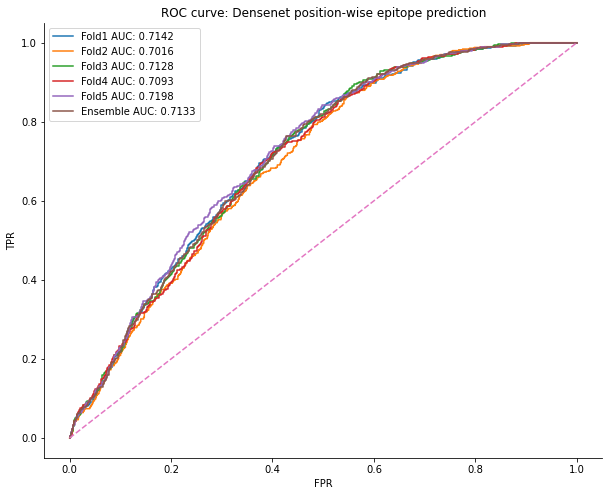

Concatenated all model predictions AUC: 0.710620469596857
Concatenated all model predictions AUC10: 0.11568617407750977
Concatenated all model predictions MCC: 0.22029589784515202
Concatenated all model predictions recall 0.636144578313253
Concatenated all model predictions precision: 0.2936596218020022
Concatenated all model predictions F1 score: 0.4018264840182648
Concatenated all model predictions accuracy: 0.6393116634799235
Latex format: & 0.711 & 0.116 & 0.22 & 0.636 & 0.294 & 0.402 & 0.639
Average AUC across all models 0.712
Average AUC10 across all models 0.112
Average CE loss across all models 0.452
Average MCC across all models 0.226
Fold threshold values: [0.155, 0.155, 0.194, 0.136, 0.174]
Average positive recall across all models 0.636
Average precision across all models 0.299
Average F1-score across all models 0.397
Average accuracy across all models 0.639
Overfit threshold values [0.126, 0.129, 0.114, 0.158, 0.144]


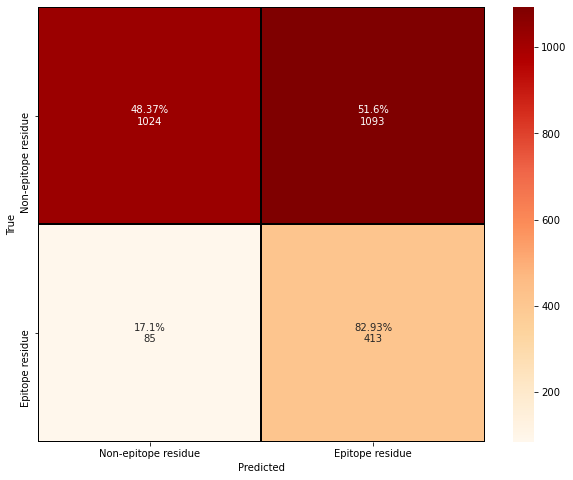

In [28]:
_, _ = evaluate_models_with_roc_curve(model, best_ce_loss_models,
                                      best_mcc_thresholds,
                                      test_set_loader, plot_title, FIGURE_DIR / "roc_curve" )